In [113]:
from util.backtest import *
from util.factor_util import *
import matplotlib.pyplot as plt
from matplotlib import cm
import itertools
from tqdm import tqdm
import warnings
from util.backtest import *


warnings.filterwarnings("ignore")

plt.style.use('seaborn')
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] =False

In [2]:
INSAMPLE_END_DATE = datetime(2021,7,1)
VALID_END_DATE = datetime(2022,6,1)
SAMPLE_END_DATE = datetime(2022,8,31)

FREQ = 'D'


df = pd.read_csv('/home/frank/document/Python/Factors/data/data_1h.csv')
df['BuyerRatio'] = df['takerBuyQuoteVol']/df['quoteAssetVolume']
df['BuyerPerTrade'] = df['takerBuyQuoteVol']/df['numberOfTrades']
df['VolumePerTrade'] = df['quoteAssetVolume']/df['numberOfTrades']

df = df.drop(['Volume','numberOfTrades'],axis= 1)
print('Dataframe prepared completed')

categories = {}
with open('/home/frank/document/Python/Factors/data/Crytpo_categories.json','r') as f:
    categories = json.loads(f.read())    
categories['all'] = df.symbol.unique()

col_list = ['Open','High','Low','Close','quoteAssetVolume','takerBuyQuoteVol','BuyerRatio']
df_data = {}
for col in col_list:
    df_data[col] = df.pivot(values = col,index = 'openTime',columns = 'symbol').astype(float)
    df_data[col].index = pd.to_datetime(df_data[col].index,unit = 'ms') #+ timedelta(hours=8)

print("Pivot table completed")

Dataframe prepared completed
Pivot table completed


In [3]:
## Calc Data
formula_list = []
input_data_list = []

with open('/home/frank/document/Python/Factors/data/formulas/all_formula_list_20230221.csv','r') as f:
    formula_list += f.read().split('\n')

with open('/home/frank/document/Python/Factors/data/data_list/all_data_list_20230221.csv','r') as f:
    input_data_list += f.read().split('\n')
    
formula_list[:5]

['Kurt', 'Kurt.Abs', 'Kurt.Abs.Kurt', 'Kurt.Abs.Max', 'Kurt.Abs.Mean']

In [57]:
market_filter = ~((df_data['quoteAssetVolume'] == 0) | df_data['quoteAssetVolume'].isna())
volume = df_data['quoteAssetVolume'].sort_index().rolling(7*24).sum().fillna(0)
volume_filter = volume[(market_filter)].rank(axis = 1,pct = True,ascending = True,method = 'dense')
GLOBAL_FILTER = market_filter & (volume_filter>0.75)
GLOBAL_FILTER = GLOBAL_FILTER.resample('D').last()
cond = GLOBAL_FILTER.shift(1)


In [245]:

name = 'Open/Close.Kurt.Abs'
name = 'Close.Pct_Change'


selected = 5
data = name.replace('_Reverse','').split('.')
formula = '.'.join(data[1:])
data = data[0]

factor1 = calc_factors(calc_input_data(df_data,data),formula).resample('D').last()#,params=[24*7]
# factor1 = df_data['Close'].pct_change(7*24).resample('D').last()
factor1 = factor1.sort_index().resample(FREQ).last()
zscore1 = factor1.add(-factor1.mean(axis = 1),axis = 0).div(factor1.std(axis = 1),axis = 0)
rk1 = zscore1.rank(axis = 1,pct = True,method = 'dense')


In [246]:
name = 'Close/Open.Skew'
name = 'Open/Close.SignedPower.Abs.Kurt'

data = name.replace('_Reverse','').split('.')
formula = '.'.join(data[1:])
data = data[0]

factor2 = calc_factors(calc_input_data(df_data,data),formula).resample('D').last()#,params=[24*7]
# factor1 = df_data['Close'].pct_change(7*24).resample('D').last()
factor2 = factor2.sort_index().resample(FREQ).last()
zscore2 = factor2.add(-factor2.mean(axis = 1),axis = 0).div(factor2.std(axis = 1),axis = 0)
rk2 = zscore2.rank(axis = 1,pct = True,method = 'dense')


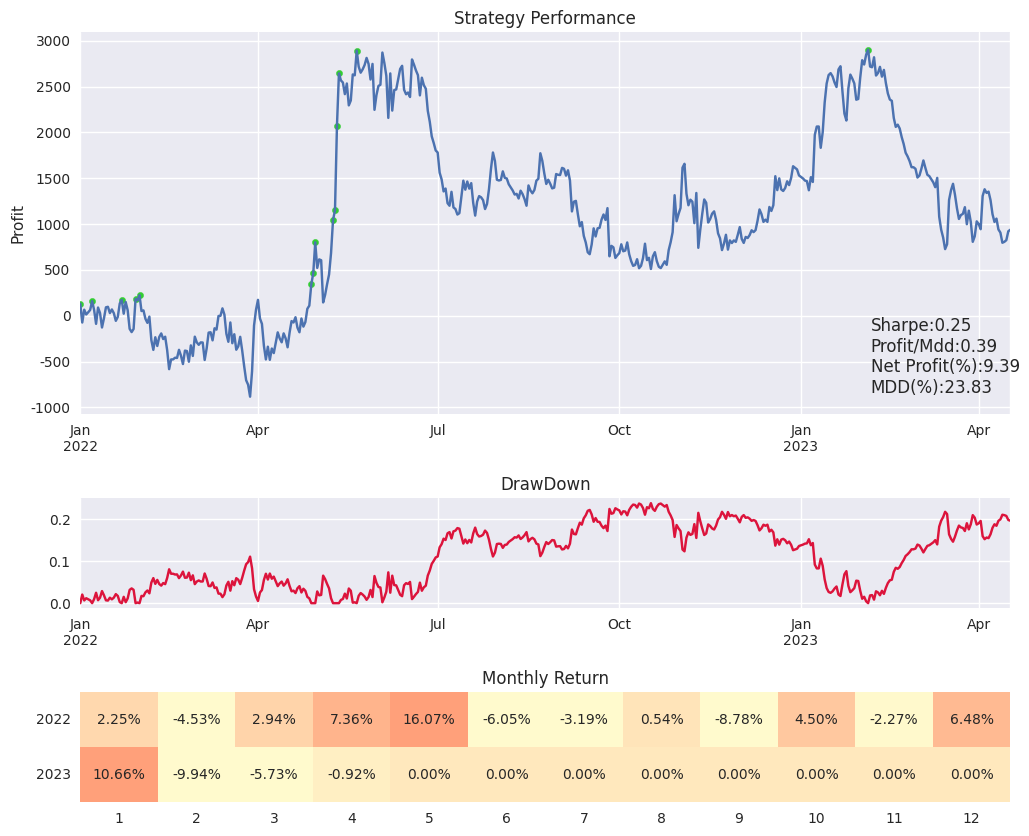

In [248]:
rk = (zscore1)[cond].rank(axis = 1,pct = True,method = 'dense',ascending = True)
rk = rk.add(-rk.mean(axis = 1),axis= 0)
zscore = (zscore1 + zscore2)
# rk = rk[zscore1.abs()>2]


long_signal = rk.copy()
short_signal = rk.copy()
long_signal[rk<0] = 0
short_signal[rk>0] = 0


ret = df_data['Close'].sort_index().resample(FREQ).last().bfill().pct_change().fillna(0)



FEE = 8
long_result = fast_backtest(ret,long_signal,fee = FEE)#.sum(axis = 1)
short_result = fast_backtest(ret,short_signal,fee = FEE)#.sum(axis = 1)

result = ((long_result + short_result)/2).sum(axis = 1)
show_return(result.loc[datetime(2022,1,1):],figsize= (12,10))

In [250]:

# rk1 = factor[GLOBAL_FILTER].stack().reset_index().rename({0:'rk1'},axis = 1)
rk1 = zscore1.stack().reset_index().rename({0:'Factor1'},axis = 1)
rk2 = zscore2.stack().reset_index().rename({0:'Factor2'},axis = 1)


ret = df_data['Close'].resample('D').last().pct_change()
ret_rk = ret.shift(-1).stack().reset_index().rename({0:'Y'},axis = 1)
ret_rk2 = ret.add(-ret.mean(axis = 1),axis = 0).shift(-1).stack().reset_index().rename({0:'ret_rk2'},axis = 1)
ret_rk3 = ret.rank(axis = 1,method = 'dense',pct = True).shift(-1).stack().reset_index().rename({0:'ret_rk3'},axis = 1)

df = pd.merge(rk1,ret_rk,on = ['openTime','symbol'])#,how = 'outer'
df = pd.merge(df,rk2,on = ['openTime','symbol'])
# df = pd.merge(df,rk3,on = ['openTime'])
# df = pd.merge(df,rk4,on = ['openTime'])

df = pd.merge(df,ret_rk2,on = ['openTime','symbol'])
df = pd.merge(df,ret_rk3,on = ['openTime','symbol'])

# df = df[(df.rk1.abs()>2) | (df.rk2.abs()>2) | (df.rk3.abs()>2) | (df.rk4.abs()>2)].dropna()

df

,openTime,symbol,Factor1,Y,Factor2,ret_rk2,ret_rk3
0,2020-01-07,bchusdt,1.080517,-0.008873,-0.378102,0.006895,1.000000
1,2020-01-07,btcusdt,-0.187607,-0.011365,1.133921,0.004403,0.750000
2,2020-01-07,ethusdt,-0.892910,-0.014770,-0.755819,0.000998,0.500000
3,2020-01-08,bchusdt,1.040658,-0.008910,-0.598373,0.009183,1.000000
4,2020-01-08,btcusdt,-0.087000,-0.029932,1.154442,-0.011839,0.200000
...,...,...,...,...,...,...,...
122807,2023-04-16,yfiusdt,-0.290381,-0.021244,0.983611,-0.007935,0.214689
122808,2023-04-16,zecusdt,-0.242736,-0.018749,-0.517197,-0.005439,0.338983
122809,2023-04-16,zenusdt,-0.007653,-0.006888,-0.422995,0.006422,0.864407
122810,2023-04-16,zilusdt,0.084928,-0.017791,-0.374455,-0.004482,0.418079


3.828375646830473


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     10.44
Date:                Tue, 18 Apr 2023   Prob (F-statistic):           2.92e-05
Time:                        23:36:39   Log-Likelihood:                 57726.
No. Observations:               54534   AIC:                        -1.154e+05
Df Residuals:                   54531   BIC:                        -1.154e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0054      0.000     14.941      0.000       0.005       0.006
Factor1        0.0014      0.000      3.872      0.000       0.001       0.002
Factor2       -0.0009      0.000     -2.379      0.017      -0.002      -0.000
==============================================================================
Omnibus:                    47879.690   Durbin-Watson:                   1.075
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         23960183.781
Skew:                           3.256   Prob(JB):                         0.00
Kurtosis:                     105.481   Cond. No.                         1.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

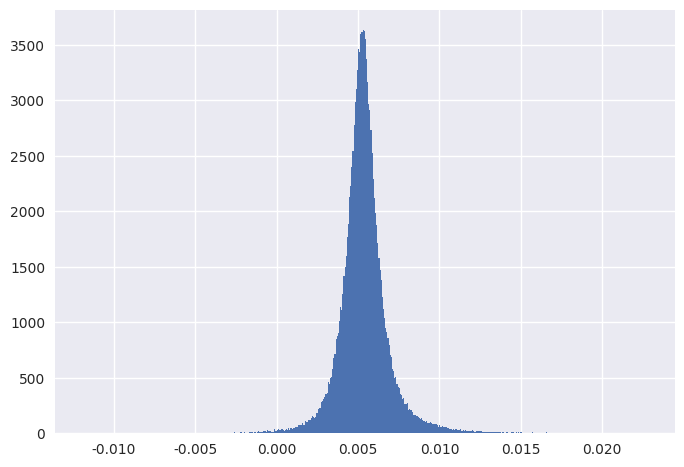

In [251]:
import statsmodels.formula.api as smf

model1 = smf.ols(formula='Y ~ Factor1 + Factor2', data=df[df.openTime<datetime(2022,1,1)]).fit()
# model1 = smf.ols(formula='ret_rk ~ rk3 ', data=df).fit()

y_pred = model1.predict(df)
y_pred.hist(bins = 500)
# print(model1.params)
print(model1.rsquared * 10**4)

model1.summary()


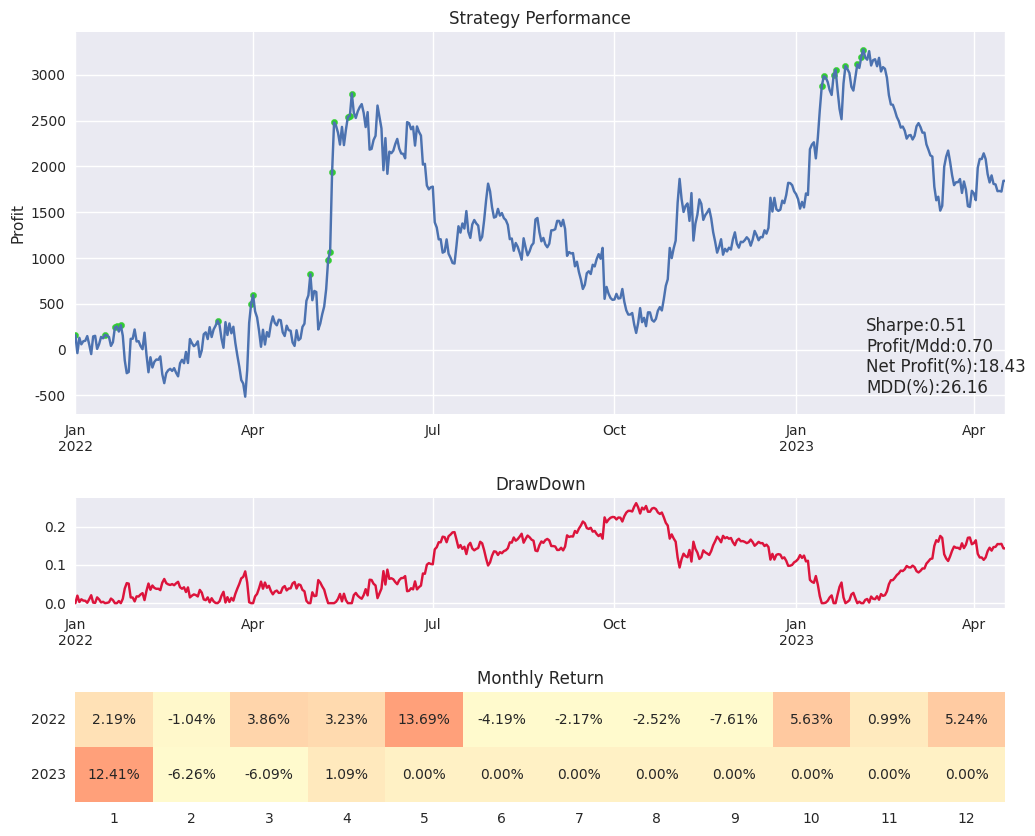

In [249]:
ret = df_data['Close'].sort_index().resample(FREQ).last().bfill().pct_change().fillna(0)


df1 = df.copy()
df1['pred'] = y_pred
rk= df1.pivot_table(columns = 'symbol',index='openTime',values='pred')[cond]#.rank(axis = 1,pct = True)

zscore = rk.add(-rk.mean(axis = 1),axis = 0).div(rk.std(axis = 1),axis = 0)

rk = rk.rank(pct = True,axis= 1,method = 'dense',ascending = True)
rk = rk.add(-rk.mean(axis = 1),axis = 0)
# rk = rk[zscore.abs()>2]

FEE = 8


long_signal = rk.copy()
short_signal = rk.copy()
long_signal[rk<0] = 0
short_signal[rk>0] = 0
long_result = fast_backtest(ret,long_signal,fee = FEE)#.sum(axis = 1)
short_result = fast_backtest(ret,short_signal,fee = FEE)#.sum(axis = 1)

result = (long_result + short_result)/2


# result = fast_backtest(ret,rk1,fee = FEE)
show_return(result.loc[datetime(2022,1,1):].sum(axis = 1))
# result.sum(axis = 1).cumsum().plot()


